In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 194MB/s]


In [ ]:
! unzip /content/brain-mri-images-for-brain-tumor-detection.zip -d /content/tumor-detection

In [ ]:
! rm -r /content/tumor-detection/brain_tumor_dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Dense, Input, Conv2D, BatchNormalization, MaxPool2D, ReLU, GlobalAveragePooling2D, Flatten, Dropout, ELU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range= (0.5, 1.5),
    validation_split=0.2
    )
test_data_gen = ImageDataGenerator(
    rescale=1./255,
    )

In [ ]:
# flow_from_directory

train_data = train_data_gen.flow_from_directory(
    directory='/content/tumor-detection',
    batch_size = 64,
    target_size=(224, 224),
    subset = 'training',
)

validation_data = train_data_gen.flow_from_directory(
    directory='/content/tumor-detection',
    batch_size = 64,
    target_size = (224, 224),
    subset = 'validation'

)
test_data = test_data_gen.flow_from_directory(
    directory='/content/tumor-detection',
    batch_size = 64,
    target_size = (224, 224),
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [ ]:
classes = {str(y): x for x, y in train_data.class_indices.items()}

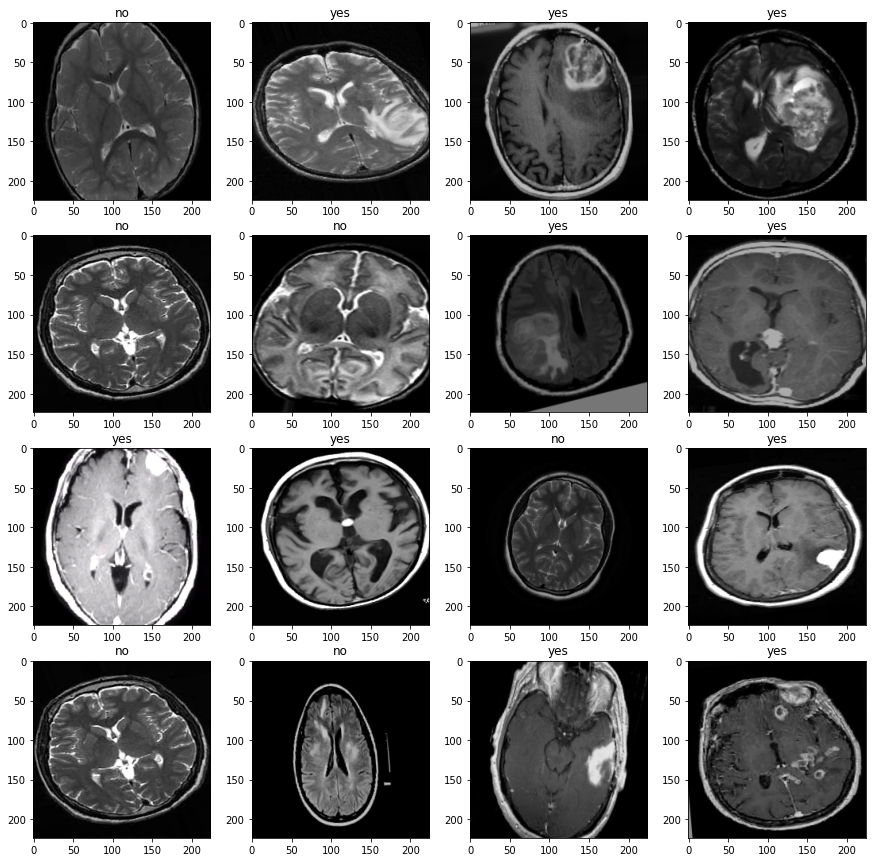

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plot = plt.subplot(4,4,i+1)
    img, label = train_data.next()
    # print(np.round([img[0].max(), img[0].min()]))
    plot.imshow(img[0])
    label_index = list(label[0]).index(1)
    plot.set_title(classes[str(label_index)])

In [ ]:
# create model from transfer learning

base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

i = base_model.input

# delet the last max_pool layer from base model after looking the base model summary

x = base_model.output
x = GlobalAveragePooling2D()(x)
fc1 = Dense(units = 64, activation ='relu')(x)
o = Dense(units = 2, activation ='softmax')(fc1)

model = Model(i, o)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# callbacks
earlystop = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/brain_vgg16_1.h5', monitor='val_loss', save_best_only=True, verbose=1)
def lr_scheduler(epoch, lr):
    decay_rate = 0.97
    decay_step = 2
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
lr_reduse = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

# complie the model
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, validation_data=validation_data, epochs=40, callbacks=[earlystop, model_checkpoint, lr_reduse ])



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
4/4 [==============================] - ETA: 0s - loss: 0.7724 - accuracy: 0.5369
Epoch 1: val_loss improved from inf to 0.65931, saving model to /content/drive/MyDrive/brain_vgg16_1.h5
4/4 [==============================] - 10s 2s/step - loss: 0.7724 - accuracy: 0.5369 - val_loss: 0.6593 - val_accuracy: 0.6200 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
4/4 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.6108
Epoch 2: val_loss improved from 0.65931 to 0.63753, saving model to /content/drive/MyDrive/brain_vgg16_1.h5
4/4 [==============================] - 6s 2s/step - loss: 0.6732 - accuracy: 0.6108 - val_loss: 0.6375 - val_accuracy: 0.6200 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.69999975495739e-05.
Epoch 3/40
4/4 [==============================] - ETA: 0s - loss: 0.6507 - acc

In [ ]:
hist = model.history.history

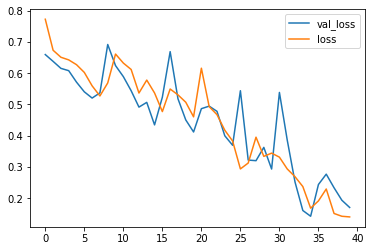

In [ ]:
plt.plot(hist['val_loss'], label='val_loss')
plt.plot(hist['loss'], label='loss')
plt.legend()
plt.show()



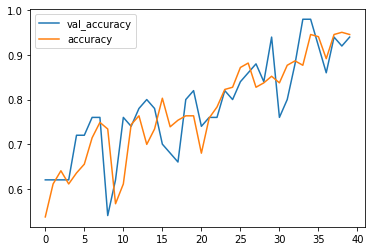

In [ ]:
plt.plot(hist['val_accuracy'], label='val_accuracy')
plt.plot(hist['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 2s 299ms/step - loss: 0.1218 - accuracy: 0.9447


[0.12179684638977051, 0.9446640610694885]